In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten,MaxPooling2D,AveragePooling2D, concatenate,Input

from math import e
from sklearn.model_selection import train_test_split
from keras.models import Model

In [2]:
from sklearn.preprocessing import StandardScaler

In [3]:
fogData = xr.open_dataset('../../../Data/FogData/CombinedFogData_25Stations.nc')
#plt.figure(figsize=[16,8])
StackFog=fogData.fogdata.stack(a=('years','months','days'))
StackFog
dd =[];
for i in range(StackFog.years.values.shape[0]):
    dd=dd+[str(StackFog.years[i].values)+'-'+str(StackFog.months[i].values)+"-"+str(StackFog.days[i].values)]
fg = xr.Dataset({'fogdata': (('time','stations'), StackFog.values.T)}, coords={'time': pd.to_datetime(dd),'stations': fogData.stations})
y=fg.fogdata.sum(dim='stations').sel(time=slice('1980-1-1','2014-12-31'))
y=y/25.0
#y

In [4]:
z500Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_500_z_daily_NovDecJan.nc')

In [5]:
z=z500Data.z.shift(time=1)

In [6]:
zTs=z[((z.time.dt.month>11) | (z.time.dt.month<2)) & (z.time.dt.year<2020)].sel(time=slice('1980-1-1','2014-12-31'),latitude=slice(90,0),longitude=slice(0,120))

In [7]:
z_train, z_test, y_train,y_test = train_test_split( zTs, y,test_size=0.20, random_state=0)

In [8]:
ztrain=z_train.values
ztrain=ztrain[:,:,:,None]
ztrain.shape
ytrain=y_train.values
ytrain=ytrain[:,None]
ytrain.shape
ztest=z_test.values
ztest=ztest[:,:,:,None]
ztest.shape
ytest=y_test.values
ytest=ytest[:,None]
ytest.shape

(434, 1)

Epoch 1/9
55/55 [==============================] - 3s 45ms/step - loss: 779.4037 - val_loss: 0.2336
Epoch 2/9
55/55 [==============================] - 2s 34ms/step - loss: 0.1948 - val_loss: 0.1748
Epoch 3/9
55/55 [==============================] - 2s 29ms/step - loss: 0.1748 - val_loss: 0.1698
Epoch 4/9
55/55 [==============================] - 1s 27ms/step - loss: 0.1673 - val_loss: 0.1699
Epoch 5/9
55/55 [==============================] - 2s 33ms/step - loss: 0.1663 - val_loss: 0.1698
Epoch 6/9
55/55 [==============================] - 2s 34ms/step - loss: 0.1689 - val_loss: 0.1701
Epoch 7/9
55/55 [==============================] - 1s 27ms/step - loss: 0.1775 - val_loss: 0.1698
Epoch 8/9
55/55 [==============================] - 2s 29ms/step - loss: 0.1711 - val_loss: 0.1720
Epoch 9/9
55/55 [==============================] - 2s 33ms/step - loss: 0.1729 - val_loss: 0.1732


/home/cccr/diptih/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/cccr/diptih/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


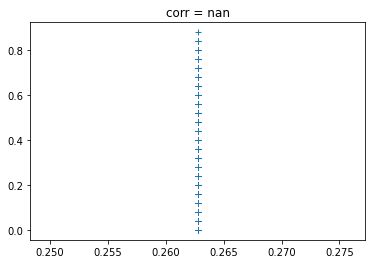

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten,MaxPooling2D,AveragePooling2D

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(7 ,7), activation='relu', input_shape=(ztrain.shape[1],ztrain.shape[2],1)))
model.add(MaxPooling2D())

model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(filters=256, kernel_size=(1,1), activation='relu'))
#model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu'))
#model.add(Conv2D(filters=3, kernel_size=(1, 1), activation='relu'))
#model.add(AveragePooling2D())

model.add(Flatten())

model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=60, activation='relu'))
model.add(Dense(units=40, activation='relu'))
#model.add(Dense(units=20, activation='relu'))

model.add(Dense(units=1, activation = 'linear'))
model.compile(optimizer='adam', loss='mae')

history = model.fit(ztrain, ytrain, validation_data=(ztest, ytest), epochs=9)
yy_test = model.predict(ztest)

test_corr = np.corrcoef(yy_test[:,0],y_test)[0,1]
plt.title('corr = %f'%test_corr)

plt.plot(yy_test,ytest,'+')
#y_test